# Analisis Heart Disease - Ensemble Learning (Boosting & Bagging)

Notebook ini akan menganalisis dataset Heart Disease menggunakan teknik ensemble learning. Dataset ini memiliki target `num` dengan 5 kelas berbeda (0-4), sehingga merupakan masalah klasifikasi multikelas.

In [35]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, ConfusionMatrixDisplay
import xgboost as xgb
from xgboost import XGBClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

## 1. Exploratory Data Analysis (EDA)

Pertama, kita akan membaca dataset dan melakukan eksplorasi data untuk memahami karakteristiknya.

In [36]:
# Read the data
df_heart = pd.read_csv('HeartDisease.csv')

# Dataset overview
print(f"Heart Disease Dataset Overview\n{'='*50}")
print(f"Shape: {df_heart.shape}")
print("\nFirst 5 rows:")
display(df_heart.head())

# Check data types and missing values
print("\nData Info:")
display(df_heart.info())

print("\nMissing Values:")
missing_values = df_heart.isnull().sum()
if missing_values.sum() > 0:
    display(missing_values[missing_values > 0])
else:
    print("No missing values found.")

print("\nDescriptive Statistics:")
display(df_heart.describe())

# Target variable analysis
print("\nTarget Variable Distribution:")
target_counts = df_heart['num'].value_counts().sort_index()
target_percents = 100 * df_heart['num'].value_counts(normalize=True).sort_index()
target_distribution = pd.DataFrame({
    'Count': target_counts,
    'Percentage (%)': target_percents
})
display(target_distribution)

Heart Disease Dataset Overview
Shape: (303, 14)

First 5 rows:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


None


Missing Values:


,0
ca,4
thal,2



Descriptive Statistics:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000



Target Variable Distribution:


,Count,Percentage (%)
num,,
0,164,54.125413
1,55,18.151815
2,36,11.881188
3,35,11.551155
4,13,4.290429


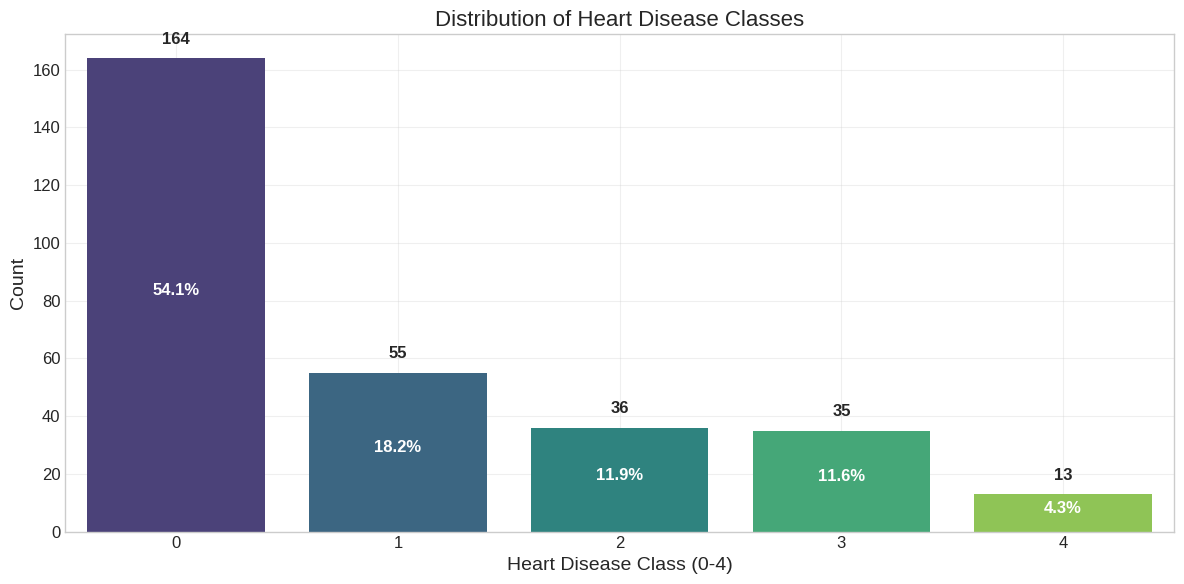

In [37]:
# Visualize target distribution
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='num', data=df_heart, palette='viridis')
plt.title('Distribution of Heart Disease Classes', fontsize=16)
plt.xlabel('Heart Disease Class (0-4)', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add count labels on top of each bar
for i, count in enumerate(target_counts):
    ax.text(i, count + 5, str(count), ha='center', fontweight='bold')
    ax.text(i, count/2, f"{target_percents.iloc[i]:.1f}%", ha='center', color='white', fontweight='bold')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

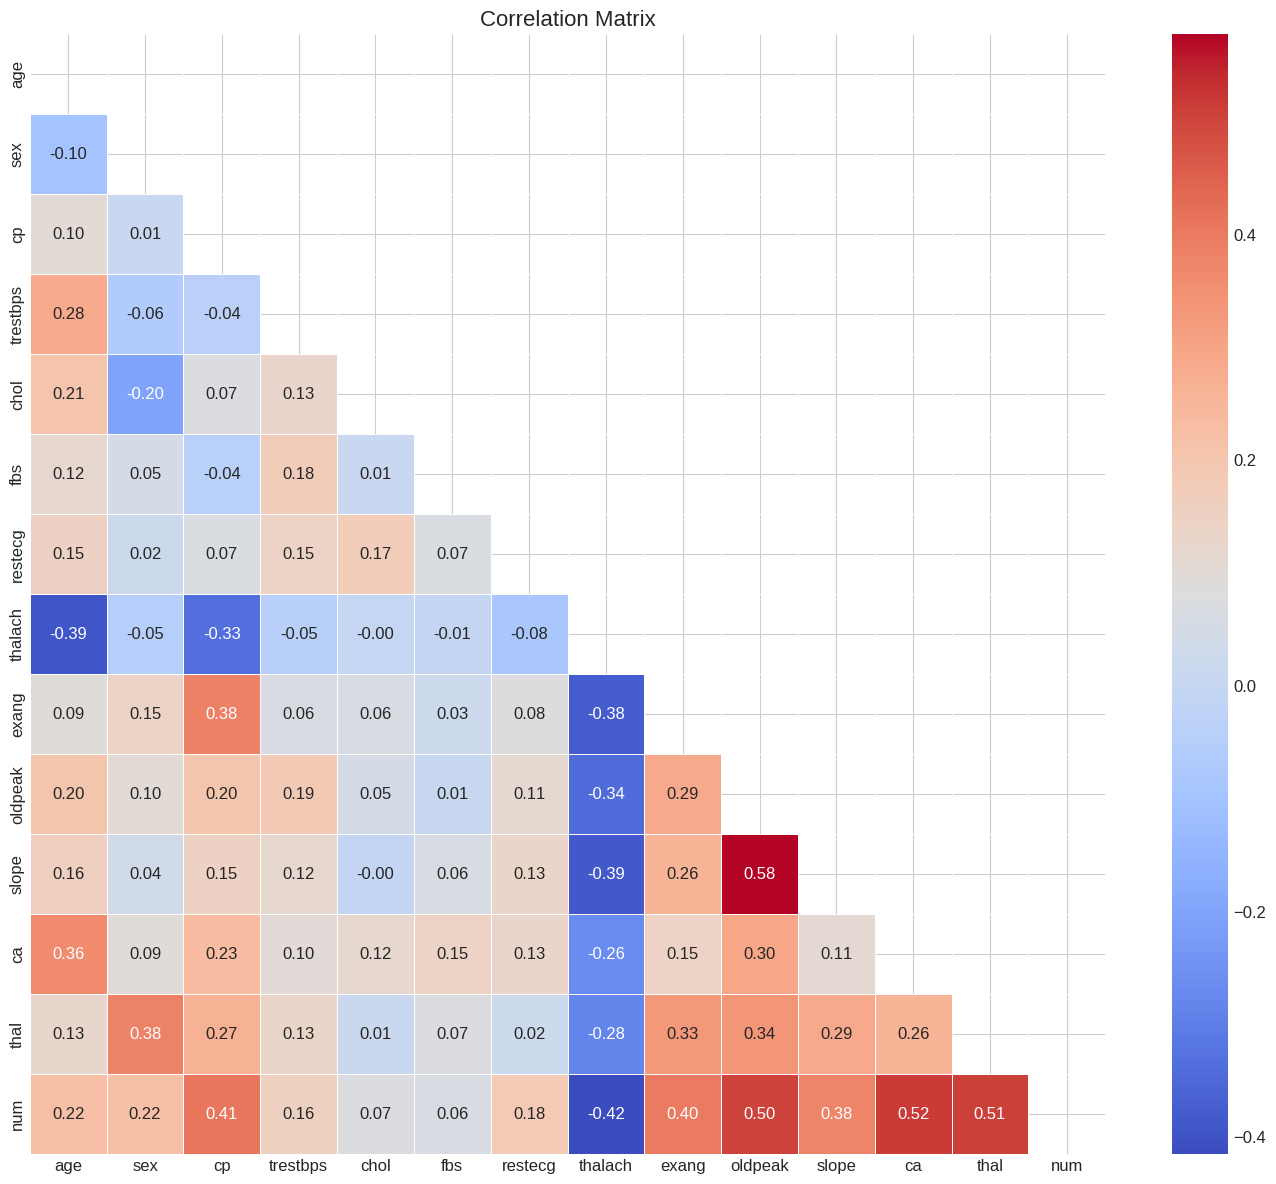

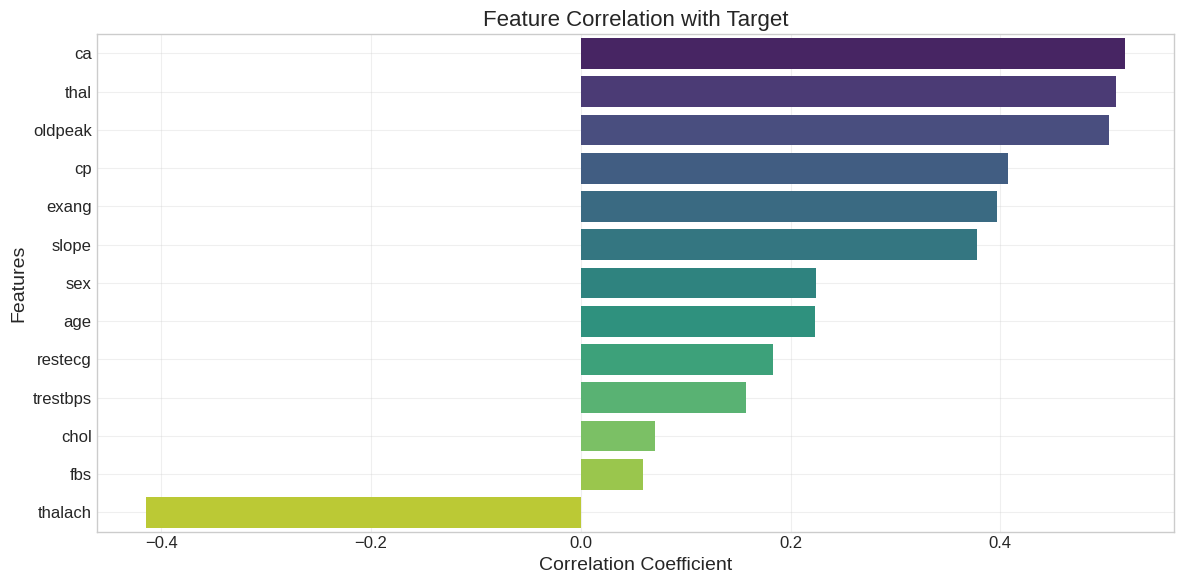

In [38]:
# Feature correlations with target
plt.figure(figsize=(14, 12))
correlation_matrix = df_heart.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, mask=mask)
plt.title('Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

# Features with highest correlation to target
target_corr = correlation_matrix['num'].drop('num').sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=target_corr.values, y=target_corr.index, palette='viridis')
plt.title('Feature Correlation with Target', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

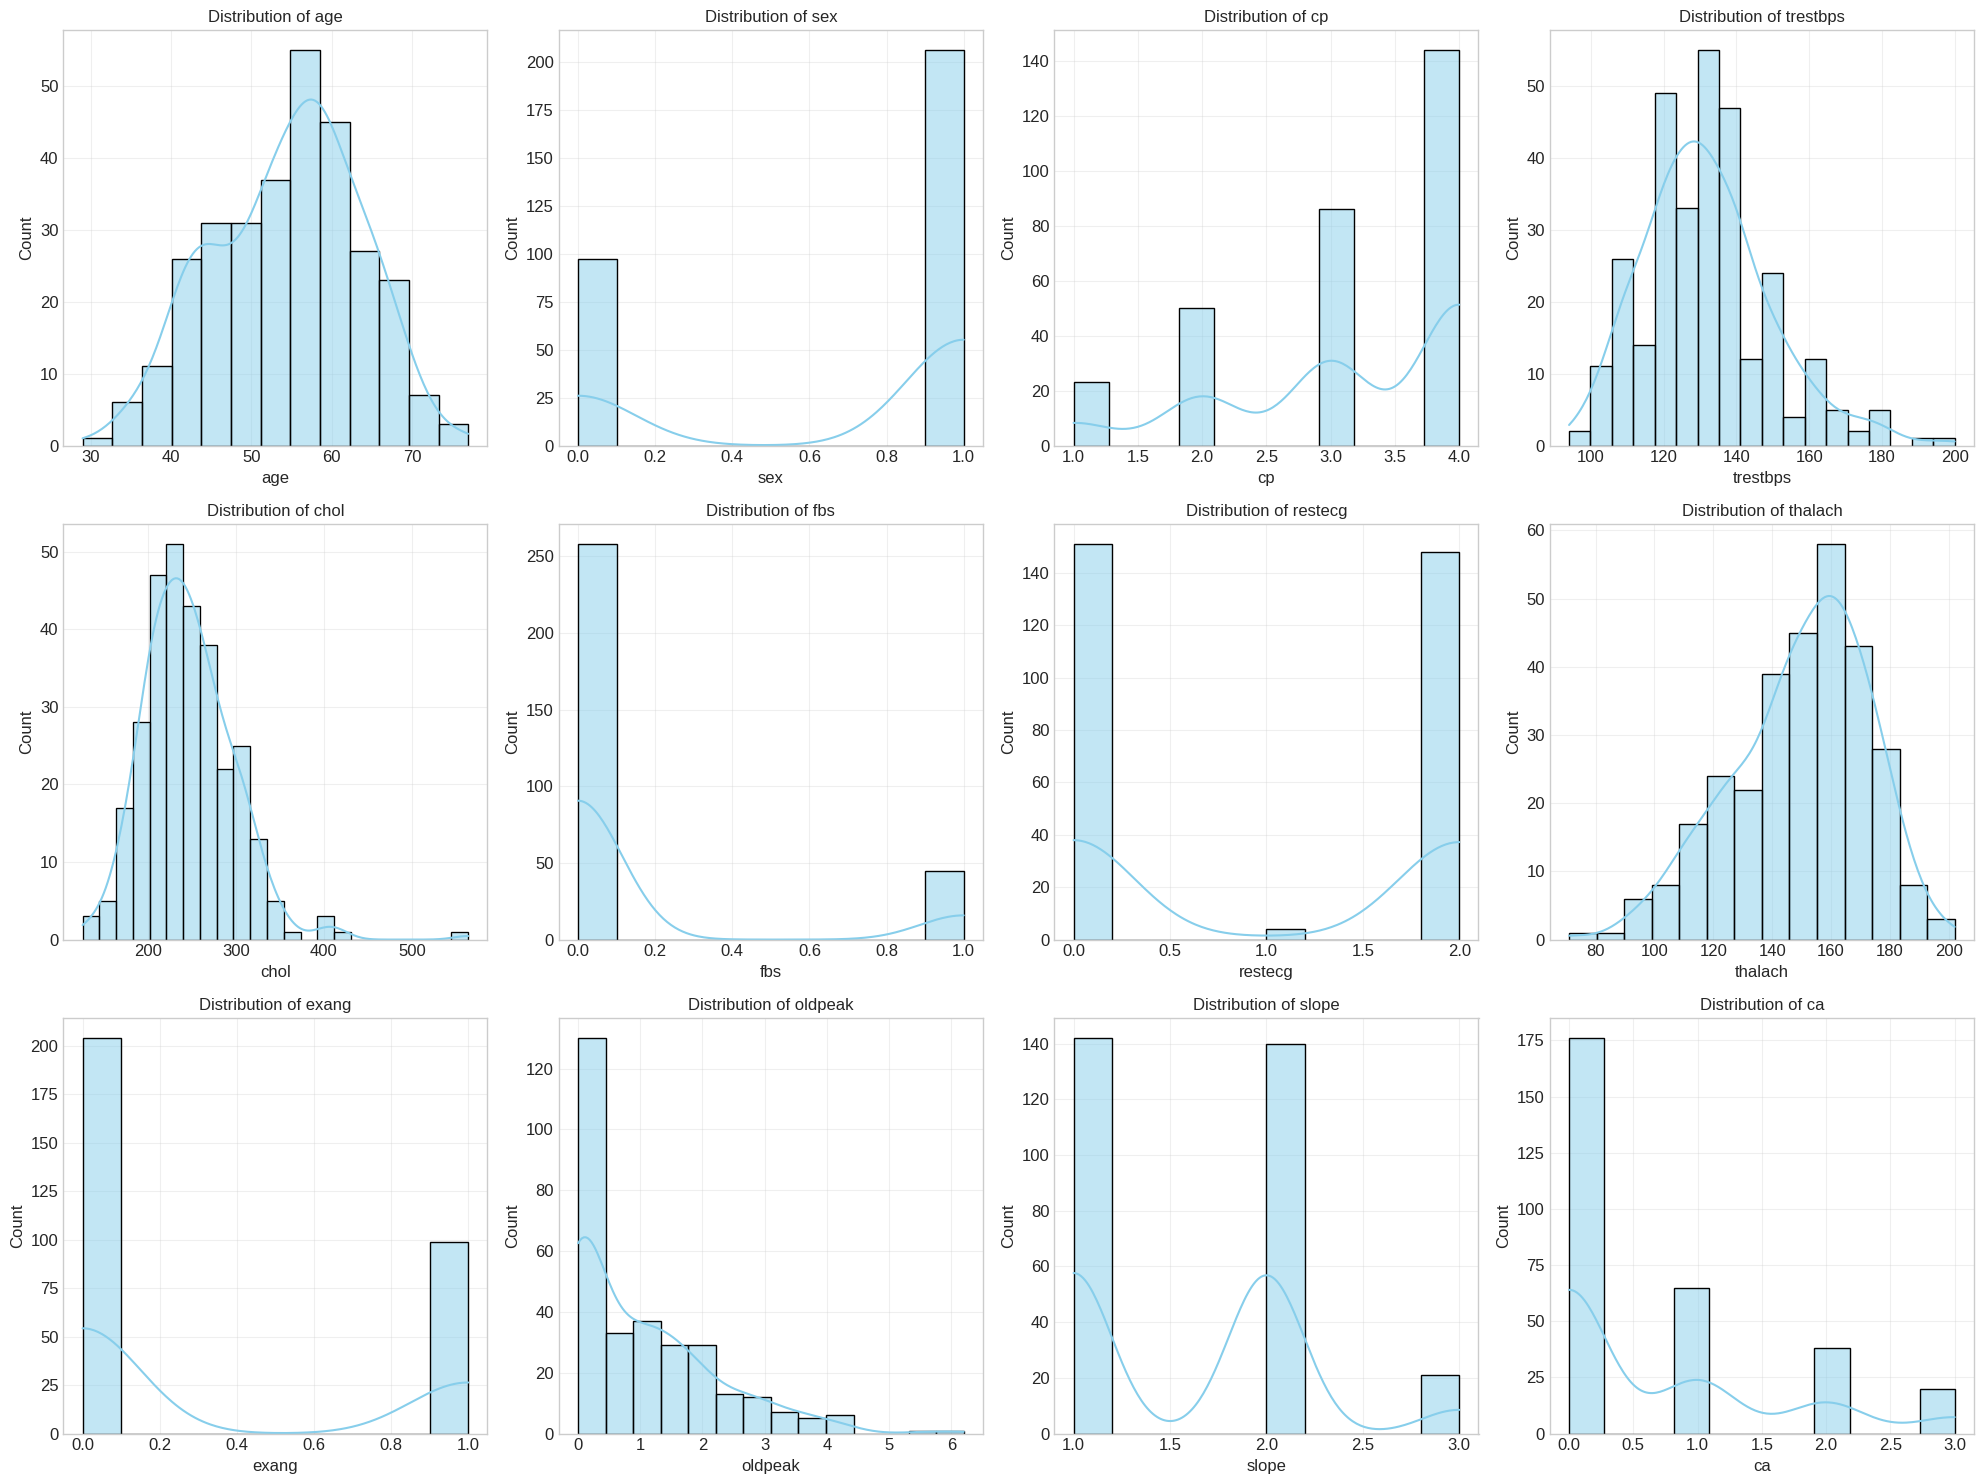

In [39]:
# Distribution of numerical features
numerical_features = df_heart.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features.remove('num')  # Remove target from feature list

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
axes = axes.flatten()

# Plot histograms for each numerical feature
for i, feature in enumerate(numerical_features):
    if i < len(axes):  # Ensure we don't go out of bounds
        sns.histplot(df_heart[feature], kde=True, ax=axes[i], color='skyblue')
        axes[i].set_title(f'Distribution of {feature}', fontsize=12)
        axes[i].grid(True, alpha=0.3)

# Remove any unused subplots
for i in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

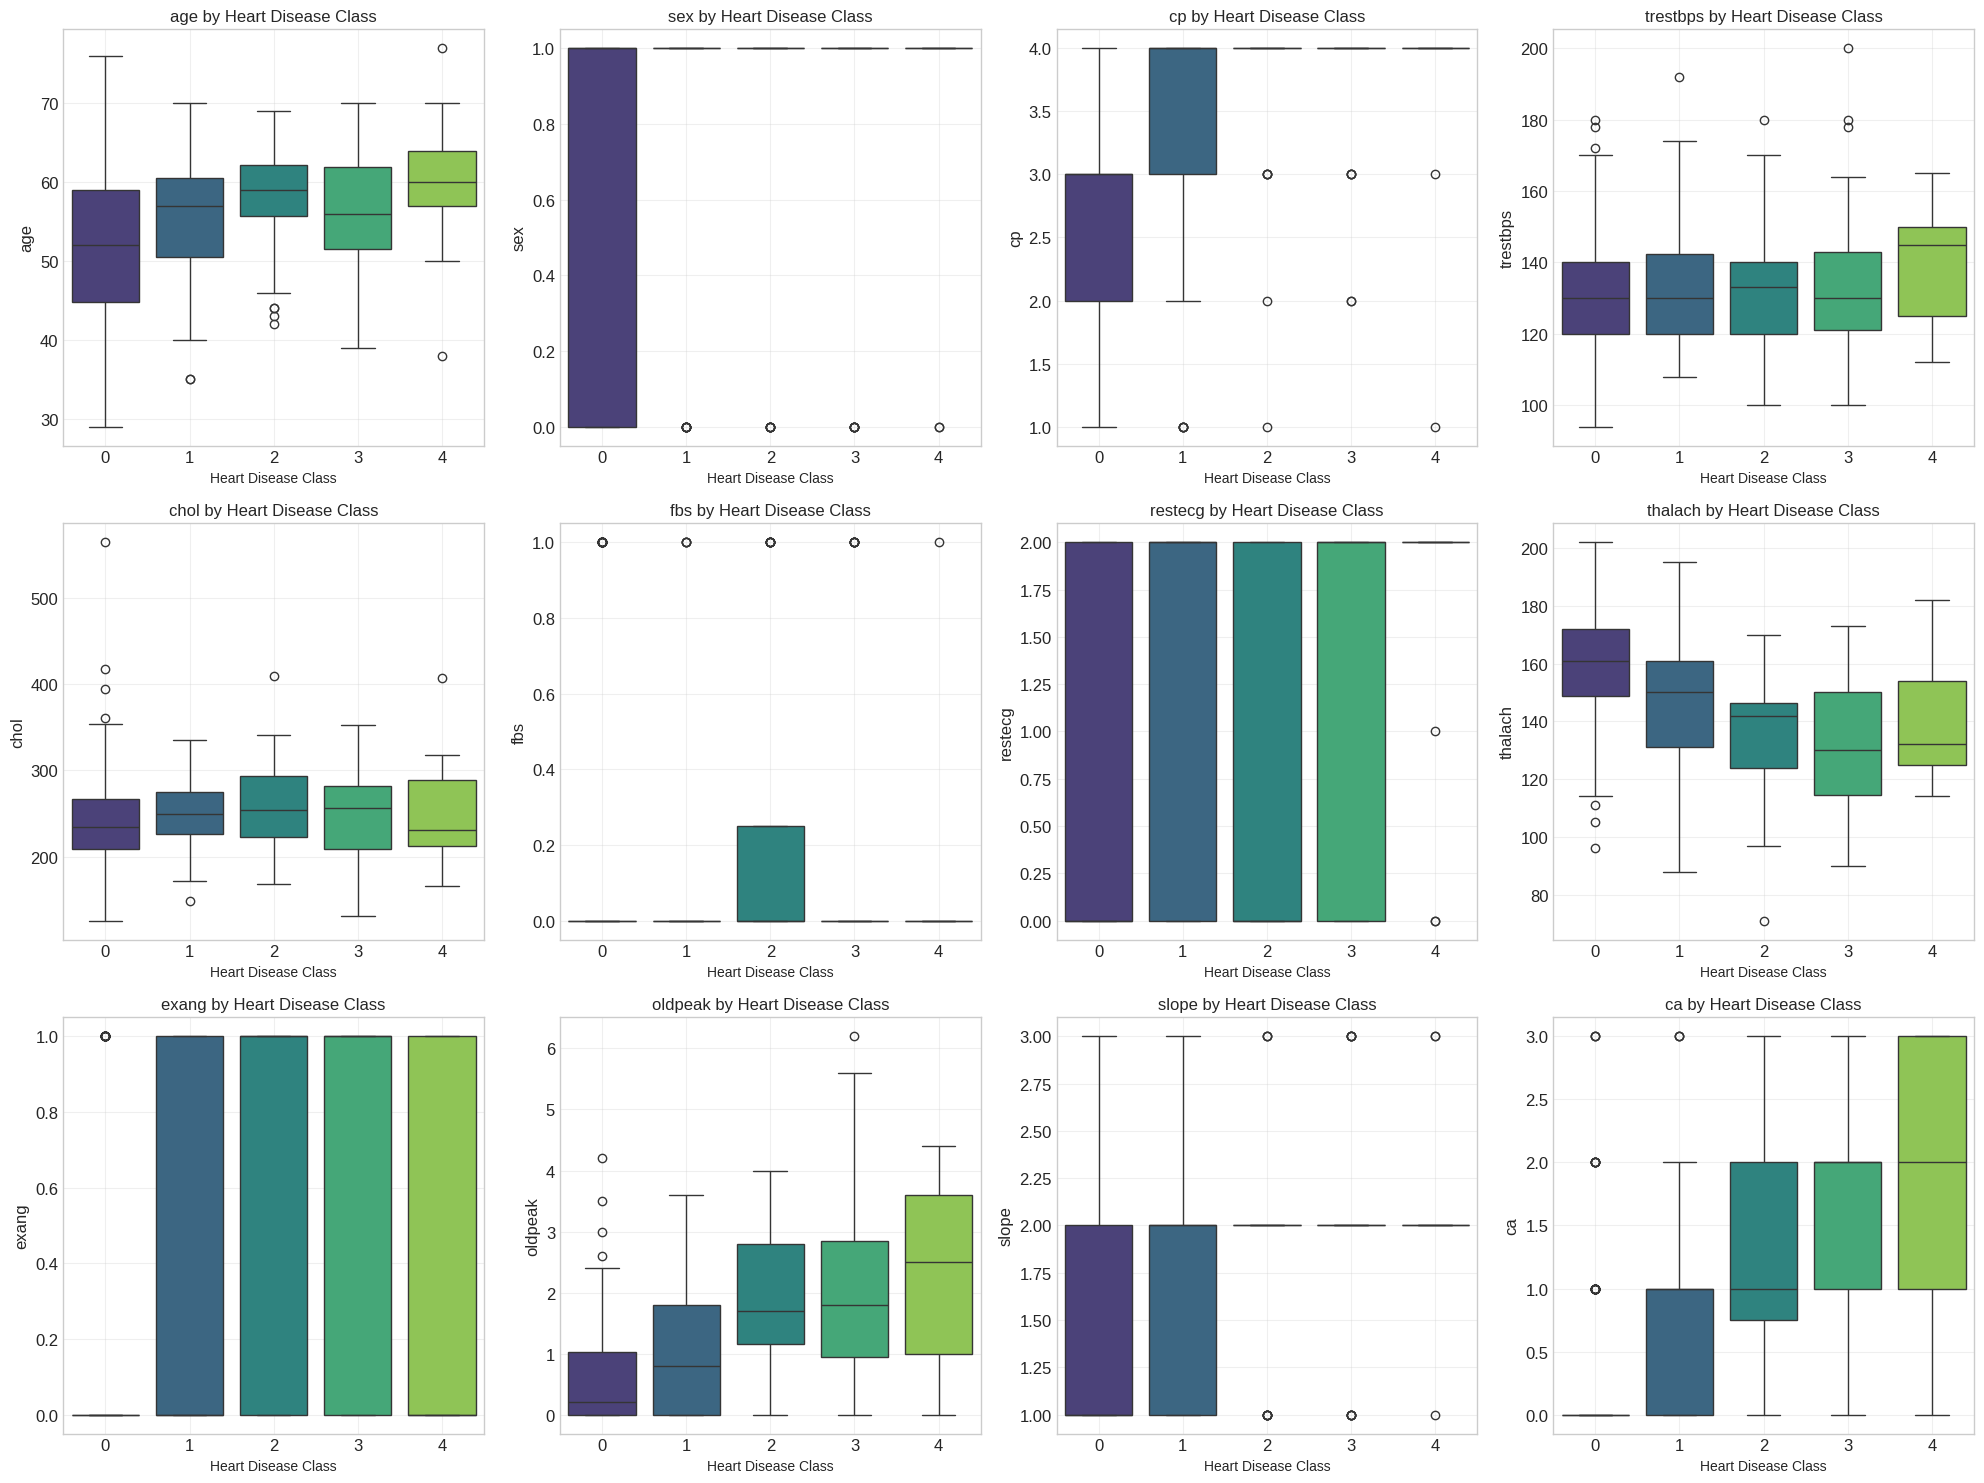

In [40]:
# Boxplots for numerical features by target
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    if i < len(axes):  # Ensure we don't go out of bounds
        sns.boxplot(x='num', y=feature, data=df_heart, ax=axes[i], palette='viridis')
        axes[i].set_title(f'{feature} by Heart Disease Class', fontsize=12)
        axes[i].set_xlabel('Heart Disease Class', fontsize=10)
        axes[i].grid(True, alpha=0.3)

# Remove any unused subplots
for i in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

<Figure size 1500x1500 with 0 Axes>

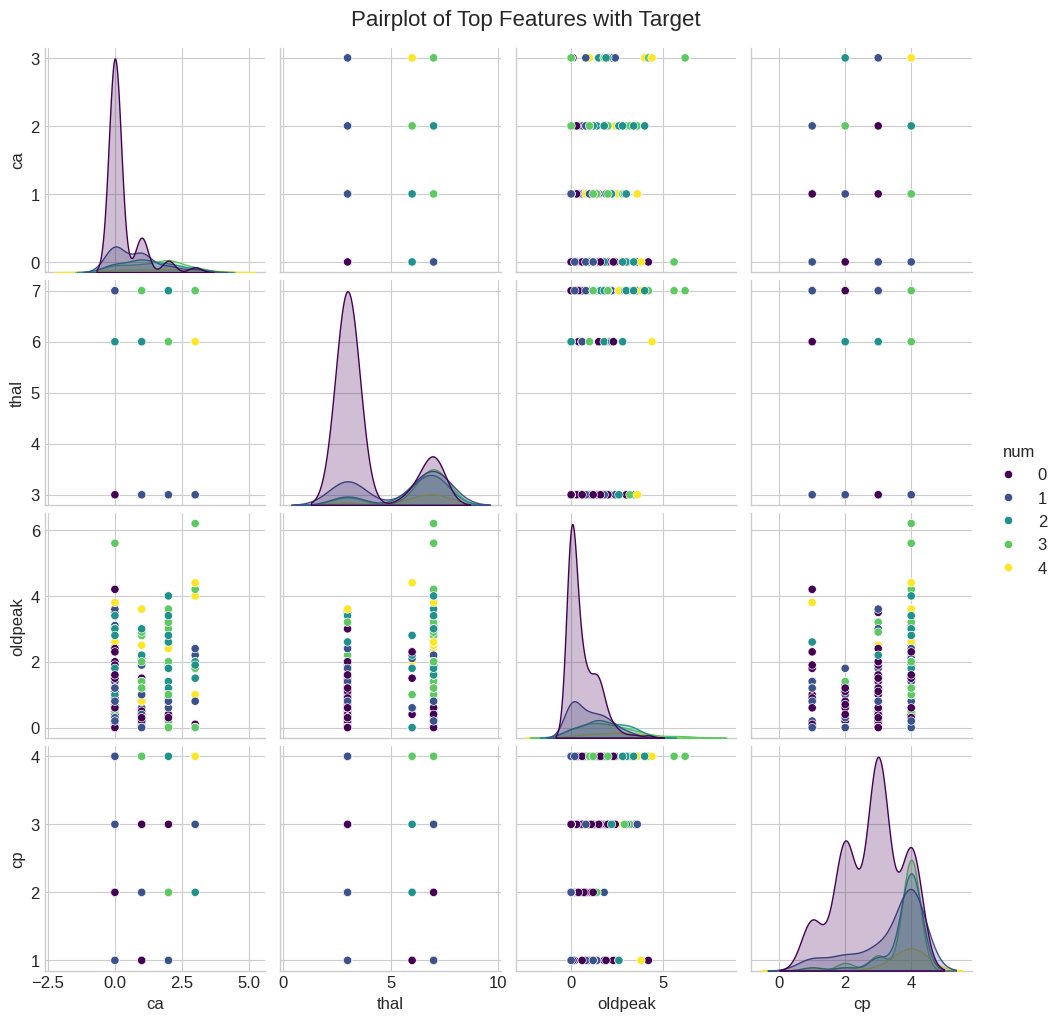

In [41]:
# Pairplot for selected features
# Select most important features based on correlation
top_features = target_corr.head(4).index.tolist()
top_features.append('num')  # Add target

plt.figure(figsize=(15, 15))
sns.pairplot(df_heart[top_features], hue='num', palette='viridis', diag_kind='kde')
plt.suptitle('Pairplot of Top Features with Target', y=1.02, fontsize=16)
plt.show()

### Interpretasi EDA Heart Disease

Dari eksplorasi data awal, kita dapat membuat beberapa observasi:

1. **Dataset Size**: Dataset memiliki 303 sampel dengan 14 fitur, termasuk target variabel 'num'.

2. **Target Distribution**: Variabel target 'num' memiliki 5 kelas (0-4) dengan distribusi yang tidak seimbang. Kelas 0 (tidak ada penyakit jantung) dan kelas 1-4 (berbagai tingkat penyakit jantung).

3. **Korelasi Fitur**: Beberapa fitur memiliki korelasi tinggi dengan target, terutama 'thal', 'ca', dan 'cp' (chest pain type).

4. **Distribusi Fitur**: Beberapa fitur seperti 'oldpeak' dan 'ca' menunjukkan distribusi yang menarik dan berbeda untuk setiap kelas penyakit jantung.

5. **Missing Values**: Tidak ada missing values yang terdeteksi dalam dataset.

Berdasarkan EDA, kita bisa melanjutkan ke tahap preprocessing dan feature engineering.

## 2. Data Preprocessing dan Feature Engineering

Kita akan melakukan beberapa langkah preprocessing dan feature engineering untuk mempersiapkan data:

In [42]:
# Check for potential non-standard missing values (e.g., '?', 'NA')
print("Checking for non-standard missing values...")
for col in df_heart.columns:
    unique_vals = df_heart[col].astype(str).unique()
    if any(val in ['?', 'NA', 'N/A', 'na', 'n/a', 'nan', ' '] for val in unique_vals):
        print(f"Column {col} has non-standard missing values.")

# Convert any special missing values to NaN
df_heart = df_heart.replace(['?', 'NA', 'N/A', 'na', 'n/a', 'nan', ' '], np.nan)

# Check missing values again
missing_after = df_heart.isnull().sum()
if missing_after.sum() > 0:
    print("\nMissing Values After Replacement:")
    display(missing_after[missing_after > 0])
else:
    print("\nNo missing values detected after replacement.")

Checking for non-standard missing values...
Column ca has non-standard missing values.
Column thal has non-standard missing values.

Missing Values After Replacement:


,0
ca,4
thal,2


In [43]:
# Feature Engineering

# 1. Create age groups
df_heart['age_group'] = pd.cut(df_heart['age'],
                              bins=[0, 40, 55, 70, 100],
                              labels=['Young', 'Middle-aged', 'Senior', 'Elderly'])

# 2. Create blood pressure categories based on medical standards
df_heart['bp_category'] = pd.cut(df_heart['trestbps'],
                                bins=[0, 120, 140, 160, 300],
                                labels=['Normal', 'Prehypertension', 'Stage 1 Hypertension', 'Stage 2 Hypertension'])

# 3. Create cholesterol categories
df_heart['chol_category'] = pd.cut(df_heart['chol'],
                                  bins=[0, 200, 240, 500],
                                  labels=['Normal', 'Borderline High', 'High'])

# 4. Heart rate reserve (estimate of cardiac fitness)
df_heart['max_heart_rate'] = 220 - df_heart['age']  # Max heart rate by age
df_heart['heart_reserve'] = df_heart['max_heart_rate'] - df_heart['thalach']

# 5. ST depression ratio (oldpeak relative to heart rate)
# Handle potential division by zero
df_heart['st_depression_ratio'] = df_heart['oldpeak'] / df_heart['thalach']
# Replace any infinities resulting from division by zero with NaN
df_heart['st_depression_ratio'] = df_heart['st_depression_ratio'].replace([np.inf, -np.inf], np.nan)
# Replace NaN values (including those from inf) with 0, as originally intended
df_heart['st_depression_ratio'] = df_heart['st_depression_ratio'].fillna(0)


# 6. Create a risk score based on multiple factors
# Higher score = higher risk
df_heart['risk_score'] = (
    (df_heart['age'] > 60).astype(int) +
    (df_heart['trestbps'] > 140).astype(int) +
    (df_heart['chol'] > 240).astype(int) +
    (df_heart['thalach'] < 120).astype(int) +
    (df_heart['oldpeak'] > 2).astype(int)
)

# Display new features
print("Sample of data with new features:")
new_features = ['age_group', 'bp_category', 'chol_category', 'heart_reserve', 'st_depression_ratio', 'risk_score']
display(df_heart[['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'num'] + new_features].head(10))

Sample of data with new features:


,age,trestbps,chol,thalach,oldpeak,num,age_group,bp_category,chol_category,heart_reserve,st_depression_ratio,risk_score
0,63,145,233,150,2.3,0,Senior,Stage 1 Hypertension,Borderline High,7,0.015333,3
1,67,160,286,108,1.5,2,Senior,Stage 1 Hypertension,High,45,0.013889,4
2,67,120,229,129,2.6,1,Senior,Normal,Borderline High,24,0.020155,2
3,37,130,250,187,3.5,0,Young,Prehypertension,High,-4,0.018717,2
4,41,130,204,172,1.4,0,Middle-aged,Prehypertension,Borderline High,7,0.008140,0
5,56,120,236,178,0.8,0,Senior,Normal,Borderline High,-14,0.004494,0
6,62,140,268,160,3.6,3,Senior,Prehypertension,High,-2,0.022500,3
7,57,120,354,163,0.6,0,Senior,Normal,High,0,0.003681,1
8,63,130,254,147,1.4,2,Senior,Prehypertension,High,10,0.009524,2
9,53,140,203,155,3.1,1,Middle-aged,Prehypertension,Borderline High,12,0.020000,1


In [44]:
# Encoding categorical features
# One-hot encoding for categorical features
categorical_features = ['age_group', 'bp_category', 'chol_category']
df_heart_encoded = pd.get_dummies(df_heart, columns=categorical_features, drop_first=True)

# Show new columns after encoding
print("New columns after encoding:")
new_columns = [col for col in df_heart_encoded.columns if col not in df_heart.columns]
print(new_columns)

New columns after encoding:
['age_group_Middle-aged', 'age_group_Senior', 'age_group_Elderly', 'bp_category_Prehypertension', 'bp_category_Stage 1 Hypertension', 'bp_category_Stage 2 Hypertension', 'chol_category_Borderline High', 'chol_category_High']


In [45]:
# Feature selection based on correlation with target
correlation_with_target = df_heart_encoded.corr()['num'].sort_values(ascending=False)
print("Feature Correlation with Target:")
display(correlation_with_target)

# Select features with correlation above threshold
correlation_threshold = 0.1
selected_features = correlation_with_target[abs(correlation_with_target) > correlation_threshold].index.tolist()
selected_features.remove('num')  # Remove target from features

print(f"\nSelected Features (correlation threshold {correlation_threshold}):")
print(f"Total selected features: {len(selected_features)}")
print(selected_features)

Feature Correlation with Target:


,num
num,1.000000
st_depression_ratio,0.535752
ca,0.518909
thal,0.509923
oldpeak,0.504092
cp,0.407075
exang,0.397057
risk_score,0.380000
slope,0.377957
heart_reserve,0.355729



Selected Features (correlation threshold 0.1):
Total selected features: 19
['st_depression_ratio', 'ca', 'thal', 'oldpeak', 'cp', 'exang', 'risk_score', 'slope', 'heart_reserve', 'age_group_Senior', 'sex', 'age', 'restecg', 'trestbps', 'bp_category_Stage 2 Hypertension', 'bp_category_Stage 1 Hypertension', 'age_group_Middle-aged', 'max_heart_rate', 'thalach']


In [46]:
# Prepare data for modeling
X = df_heart_encoded[selected_features]
y = df_heart_encoded['num']

# *** ADDED CHECK FOR NA VALUES IN X ***
print("\nChecking for NaN values in X before processing:")
nan_in_X = X.isnull().sum()
if nan_in_X.sum() > 0:
    print("NaN values found in the following features:")
    display(nan_in_X[nan_in_X > 0])
    # Option 1: Fill NaNs - simple imputation (e.g., mean for numerical, mode for others)
    # Identify columns with NaNs
    cols_with_nan = nan_in_X[nan_in_X > 0].index.tolist()
    for col in cols_with_nan:
        if col in X.select_dtypes(include=np.number).columns:
            # Impute numerical NaNs with mean (or median)
            X[col].fillna(X[col].mean(), inplace=True)
            print(f"Filled NaN in numerical column '{col}' with mean.")
        # Note: For categorical features, pd.get_dummies should have handled them,
        # but if NaNs persisted or were introduced elsewhere, mode imputation could be used.
        # For simplicity, if non-numerical NaNs are found here, we assume they
        # might be from engineered features or original data issues.
        # Add specific handling if needed based on identified columns.
else:
    print("No NaN values found in X.")
# *** END ADDED CHECK ***


# Standardize numerical features
# Now we can assume numerical_features in X are clean if imputation was done above
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_encoded = [col for col in X.columns if col not in numerical_features]

# Create preprocessing pipeline
# Add an imputer for numerical features within the ColumnTransformer
# If NaNs were already filled above, this imputer isn't strictly necessary
# for numerical features, but it's good practice if not filled globally.
# However, since the error points to AdaBoost and NaNs, let's ensure
# everything is clean before the models. The most likely culprit
# is NaNs in columns that are NOT numerical.
# Let's revisit the imputation strategy. It's better to impute *all* NaNs in X
# before the ColumnTransformer, or integrate imputation for all types within it.

# Let's simplify: check for NaNs in X and fill them *before* defining the preprocessor
# and splitting the data. This ensures X is clean before any model sees it.

# Let's re-do the check and filling more broadly:
print("\nRe-checking and filling NaN values in X before processing:")
nan_in_X_final = X.isnull().sum()
if nan_in_X_final.sum() > 0:
    print("NaN values found in the following features (final check):")
    display(nan_in_X_final[nan_in_X_final > 0])
    # Impute all columns with NaNs. Use mean for numerical, mode for others.
    for col in nan_in_X_final[nan_in_X_final > 0].index.tolist():
        if col in X.select_dtypes(include=np.number).columns:
            X[col].fillna(X[col].mean(), inplace=True)
            print(f"Filled NaN in numerical column '{col}' with mean.")
        else:
            # Impute non-numerical NaNs (e.g., from one-hot encoded, though unlikely after get_dummies) with mode
            mode_val = X[col].mode()[0] if not X[col].mode().empty else 0 # Handle empty mode
            X[col].fillna(mode_val, inplace=True)
            print(f"Filled NaN in non-numerical column '{col}' with mode.")
else:
    print("No NaN values found in X.")


# Now define the ColumnTransformer - it only needs scaling as NaNs are handled
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
        # No imputer needed here if NaNs are already filled in X
    ],
    remainder='passthrough'  # Keep non-transformed columns
)

# Apply preprocessing - StandardScaler will not see NaNs now
X_processed = preprocessor.fit_transform(X)

# X_processed is a numpy array after ColumnTransformer.
# Convert it back to DataFrame to retain column names for feature importance later
# and to ensure consistency if subsequent steps expect a DataFrame.
# This step needs careful handling of column names.
# The ColumnTransformer outputs numerical columns first (scaled), then remainder (passed through).
scaled_cols = numerical_features
passthrough_cols = categorical_encoded # These were already in X and passed through

# Reconstruct column names - assuming order is preserved
X_processed = pd.DataFrame(
    X_processed,
    columns=scaled_cols + passthrough_cols
)


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"\nFeature distribution:\n")
print(f"- Numerical features: {len(numerical_features)}")
print(f"- Categorical features (encoded): {len(categorical_encoded)}")


Checking for NaN values in X before processing:
NaN values found in the following features:


,0
ca,4
thal,2


Filled NaN in numerical column 'ca' with mean.
Filled NaN in numerical column 'thal' with mean.

Re-checking and filling NaN values in X before processing:
No NaN values found in X.
Training set shape: (242, 19)
Testing set shape: (61, 19)

Feature distribution:

- Numerical features: 15
- Categorical features (encoded): 4


## 3. Modeling dengan Ensemble Techniques

Kita akan mengimplementasikan dan membandingkan lima model ensemble learning:
1. Random Forest (Bagging)
2. AdaBoost (Boosting)
3. Gradient Boosting (Boosting)
4. XGBoost (Boosting)
5. Bagging Decision Tree (Bagging)

In [47]:
# Function to evaluate model performance for multiclass classification
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # For multi-class ROC curve, we need probability predictions
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
    else:
        # If predict_proba is not available, create a dummy probability array
        n_classes = len(np.unique(y))
        y_prob = np.zeros((len(y_test), n_classes))
        for i, val in enumerate(y_pred):
            y_prob[i, int(val)] = 1

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Calculate AUC for multi-class
    n_classes = len(np.unique(y))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Convert y_test to one-hot encoding
    y_test_onehot = pd.get_dummies(y_test).values

    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        # For multi-class classification, convert to one-vs-rest
        y_test_binary = (y_test == i).astype(int)
        if i < y_prob.shape[1]:  # Check if class is in probability predictions
            fpr[i], tpr[i], _ = roc_curve(y_test_binary, y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    if y_prob.shape[1] == n_classes:  # Only if we have probabilities for all classes
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), y_prob.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    else:
        roc_auc["micro"] = np.mean([roc_auc[i] for i in range(n_classes) if i in roc_auc])

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Feature Importance (if available)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        feature_importance = pd.DataFrame({
            'Feature': X_train.columns[indices],
            'Importance': importances[indices]
        })
    else:
        feature_importance = pd.DataFrame()

    # Return results
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc["micro"],
        'confusion_matrix': cm,
        'feature_importance': feature_importance,
        'fpr': fpr,
        'tpr': tpr,
        'model': model  # Save the model itself
    }

    return results

In [48]:
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'Bagging': BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), random_state=42)
}

# Anti-overfitting and hyperparameter tuning
def tune_model(model, param_grid, X_train, y_train, cv=5):
    # Create StratifiedKFold for cross-validation
    strat_kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # Create grid search with cross-validation
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=strat_kfold,
        scoring='f1_weighted',  # Use weighted F1 for multiclass
        n_jobs=-1,  # Use all available cores
        verbose=1
    )

    # Fit the grid search
    grid_search.fit(X_train, y_train)

    # Print results
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_

In [49]:
# Define parameter grids for each model
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt']
    },
    'AdaBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1, 1.0],
        'estimator__max_depth': [1, 3]  # Fixed parameter name from base_estimator to estimator
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 0.1]
    },
    'Bagging': {
        'n_estimators': [10, 20],
        'max_samples': [0.5, 0.7, 1.0],
        'max_features': [0.5, 0.7, 1.0],
        'bootstrap': [True],
        'bootstrap_features': [False, True]
    }
}

In [50]:
# Tune and evaluate models
tuned_models = {}
results = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Tuning {name}...")
    tuned_models[name] = tune_model(model, param_grids[name], X_train, y_train)

    print(f"\nEvaluating {name}...")
    results[name] = evaluate_model(tuned_models[name], X_train, X_test, y_train, y_test, name)

    # Print key metrics
    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print(f"Precision: {results[name]['precision']:.4f}")
    print(f"Recall: {results[name]['recall']:.4f}")
    print(f"F1 Score: {results[name]['f1_score']:.4f}")
    print(f"ROC AUC: {results[name]['roc_auc']:.4f}")


Tuning Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.5273

Evaluating Random Forest...
Accuracy: 0.5738
Precision: 0.4734
Recall: 0.5738
F1 Score: 0.5161
ROC AUC: 0.8662

Tuning AdaBoost...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'estimator__max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 100}
Best cross-validation score: 0.5601

Evaluating AdaBoost...
Accuracy: 0.5246
Precision: 0.5000
Recall: 0.5246
F1 Score: 0.5109
ROC AUC: 0.8473

Tuning Gradient Boosting...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best cross-validation score: 0.5416

Evaluating Gradient Boosting...
Accuracy: 0.4918
Precision: 0.4767
Recall: 0.4918
F1 Score: 0.4841
ROC A

In [51]:
# Collect results in a dataframe for comparison
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

for name, result in results.items():
    metrics_df = pd.concat([metrics_df, pd.DataFrame({
        'Model': [name],
        'Accuracy': [result['accuracy']],
        'Precision': [result['precision']],
        'Recall': [result['recall']],
        'F1 Score': [result['f1_score']],
        'ROC AUC': [result['roc_auc']]
    })], ignore_index=True)

# Display metrics
display(metrics_df.sort_values('F1 Score', ascending=False).style.highlight_max(axis=0, color='lightgreen'))

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
3,XGBoost,0.573770,0.539338,0.573770,0.552953,0.846681
4,Bagging,0.573770,0.511840,0.573770,0.535007,0.844800
0,Random Forest,0.573770,0.473380,0.573770,0.516074,0.866232
1,AdaBoost,0.524590,0.500000,0.524590,0.510929,0.847286
2,Gradient Boosting,0.491803,0.476736,0.491803,0.484104,0.785407


## 4. Visualization and Interpretation of Results

<Figure size 1400x800 with 0 Axes>

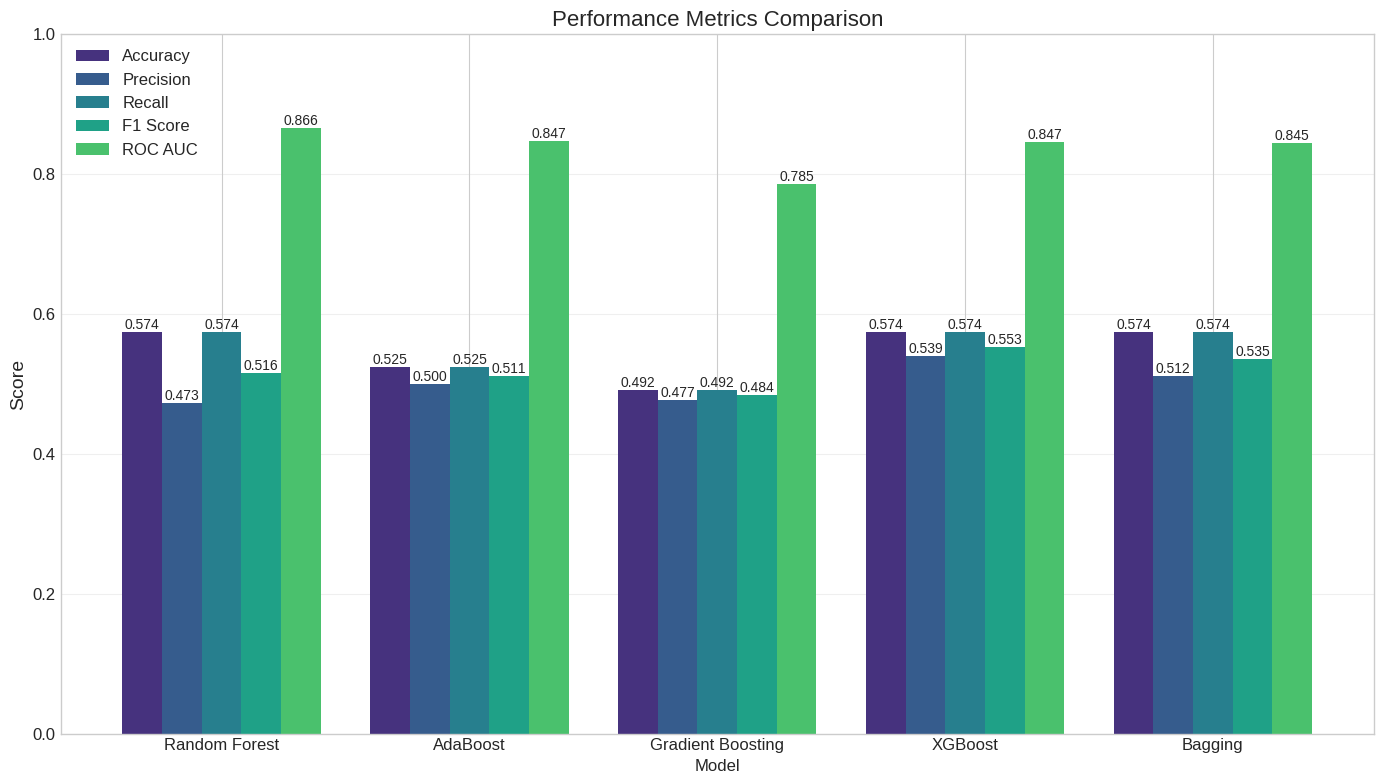

In [52]:
# Visualize metrics comparison
plt.figure(figsize=(14, 8))
metrics_df_plot = metrics_df.set_index('Model')
ax = metrics_df_plot.plot(kind='bar', figsize=(14, 8), rot=0, width=0.8)
plt.title('Performance Metrics Comparison', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.legend(fontsize=12)

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=10)

plt.tight_layout()
plt.show()

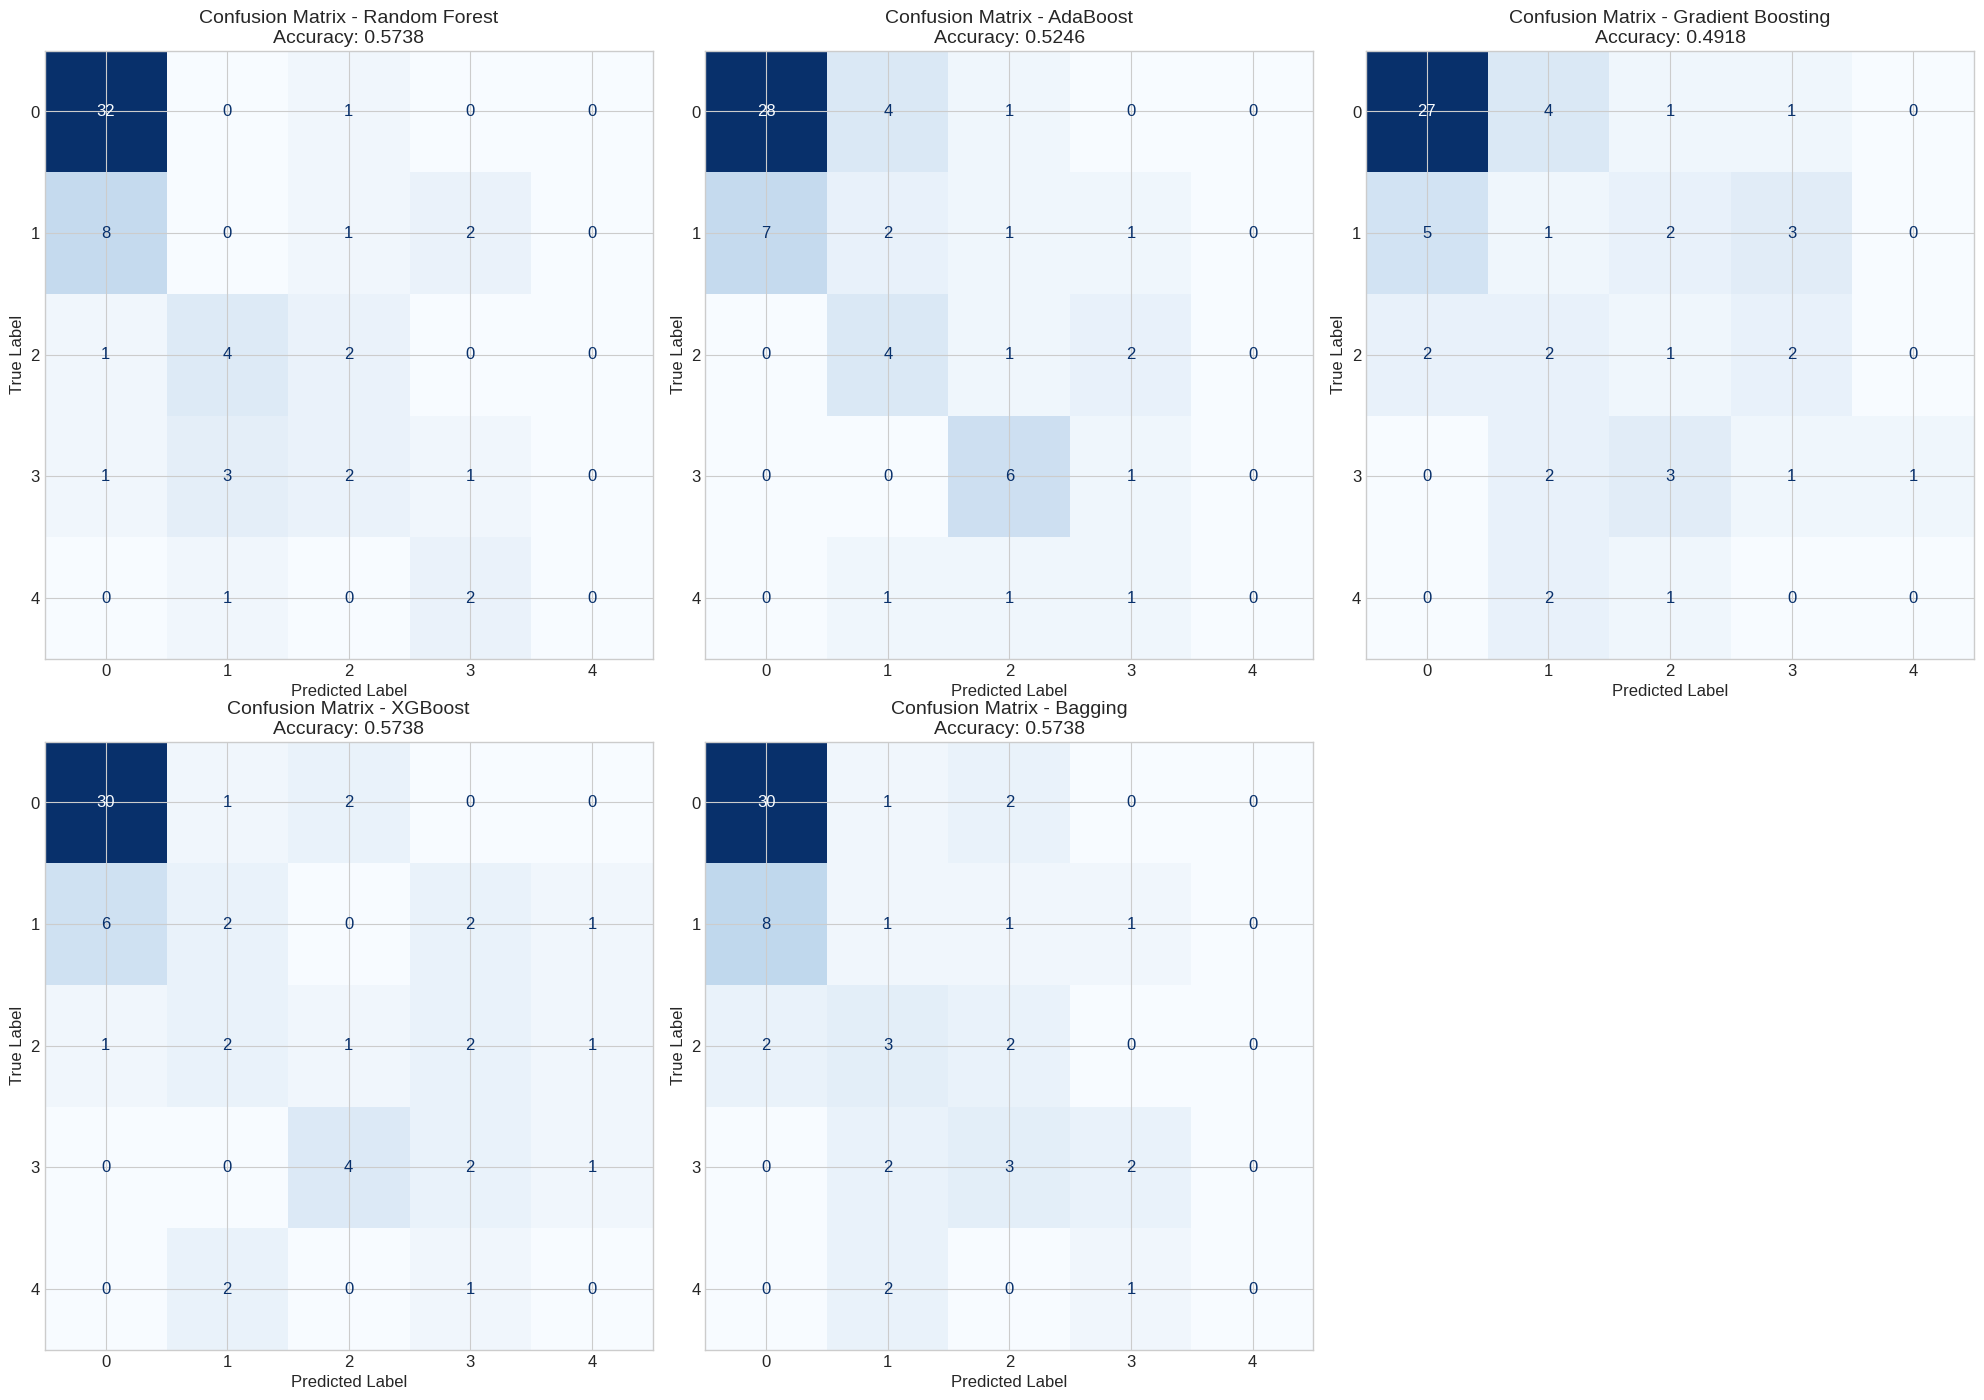

In [53]:
# Plot confusion matrices
n_classes = len(np.unique(y))
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
axes = axes.flatten()

for i, (name, result) in enumerate(results.items()):
    if i < len(axes):
        cm = result['confusion_matrix']
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(n_classes))
        disp.plot(ax=axes[i], values_format='d', colorbar=False, cmap='Blues')
        disp.ax_.set_title(f'Confusion Matrix - {name}', fontsize=14)
        disp.ax_.set_xlabel('Predicted Label', fontsize=12)
        disp.ax_.set_ylabel('True Label', fontsize=12)

        # Add accuracy in title
        accuracy = result['accuracy']
        disp.ax_.set_title(f'Confusion Matrix - {name}\nAccuracy: {accuracy:.4f}', fontsize=14)

# Remove empty subplots
for i in range(len(results), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

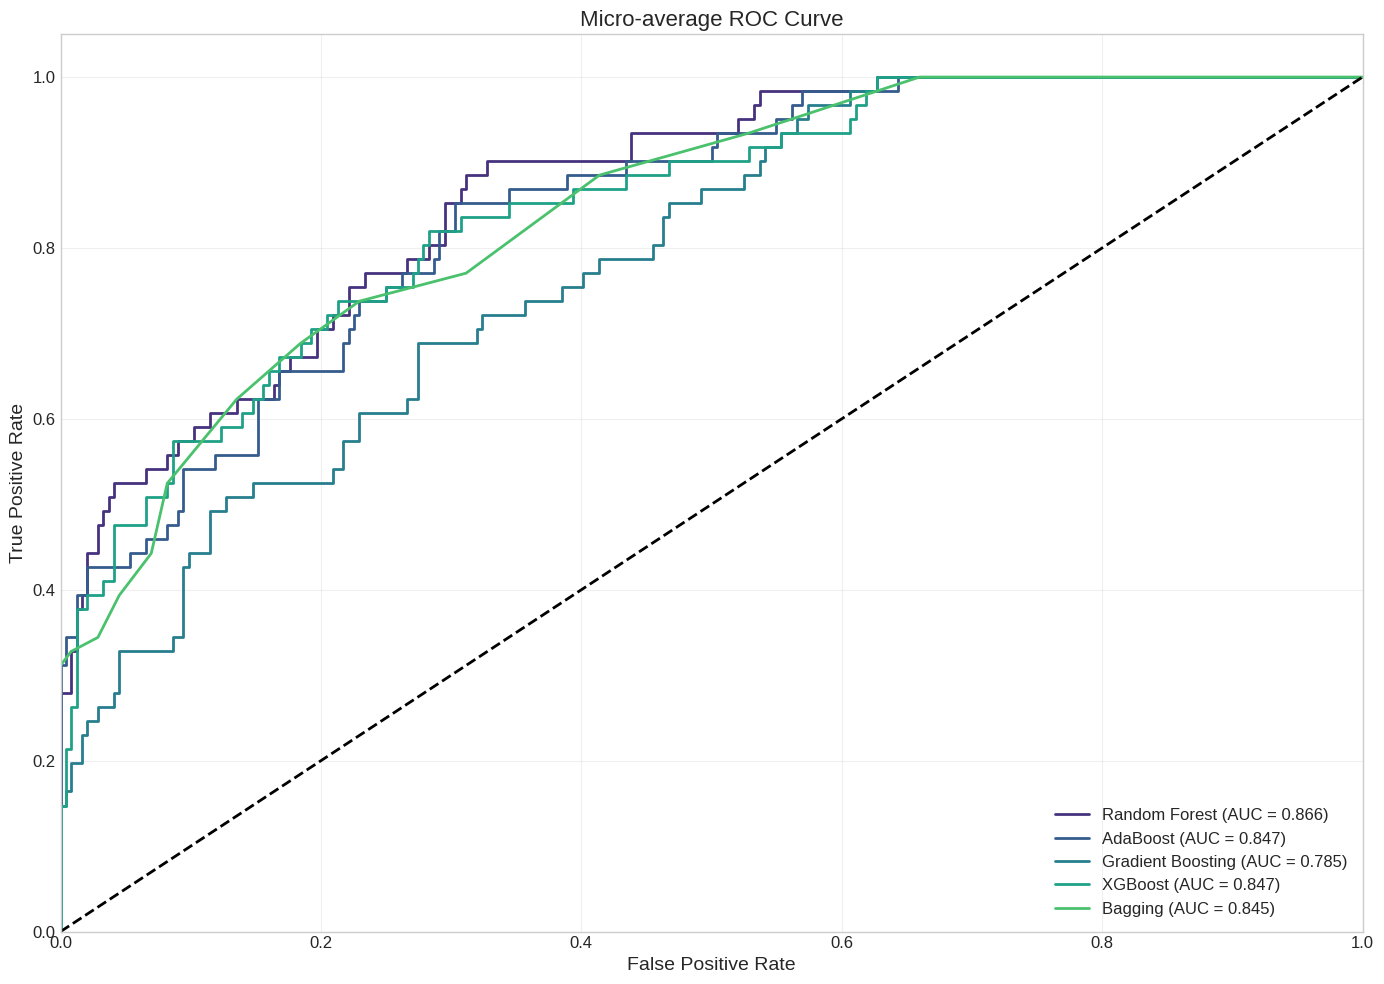

In [54]:
# ROC Curves
plt.figure(figsize=(14, 10))

for name, result in results.items():
    plt.plot(result['fpr']['micro'], result['tpr']['micro'],
             label=f'{name} (AUC = {result["roc_auc"]:.3f})',
             linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Micro-average ROC Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

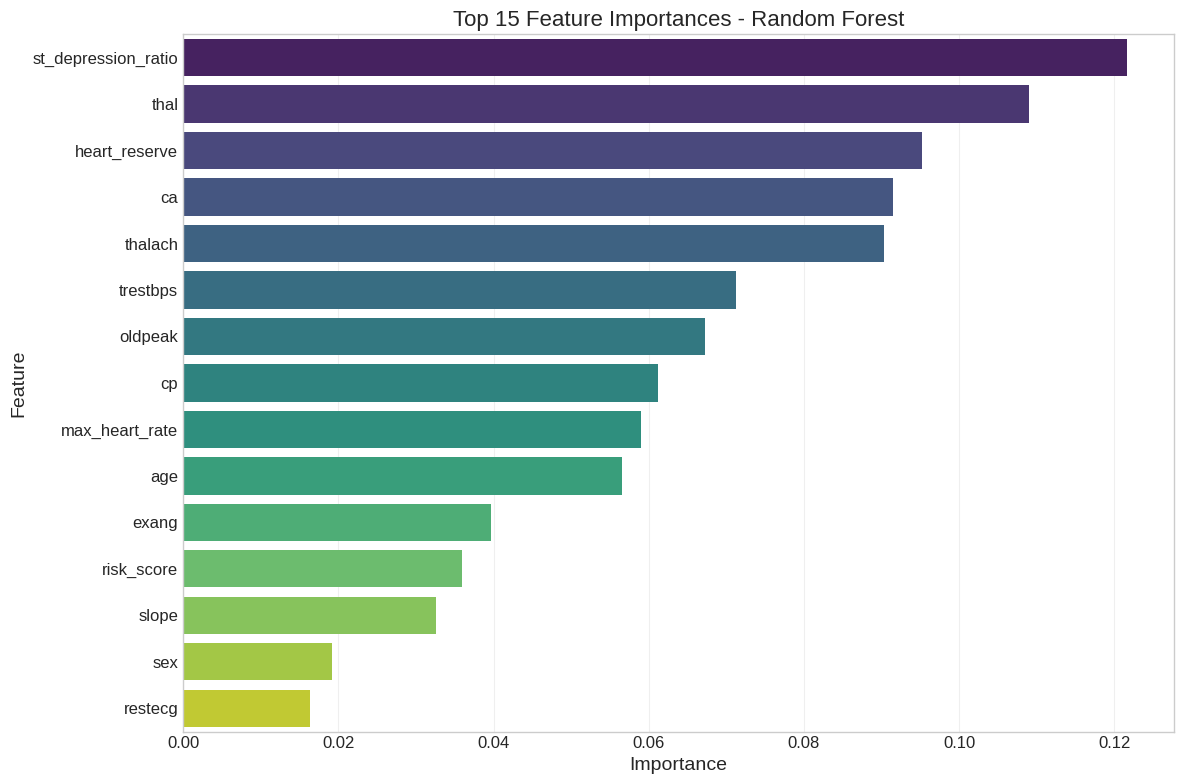

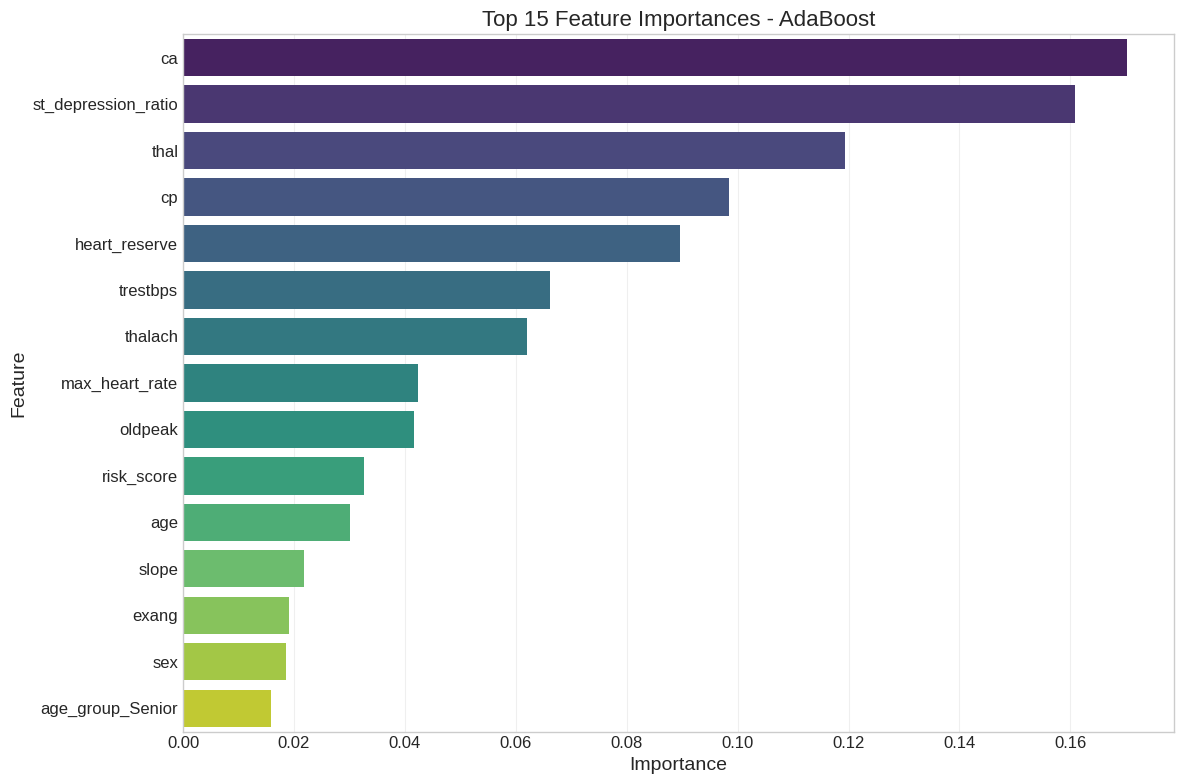

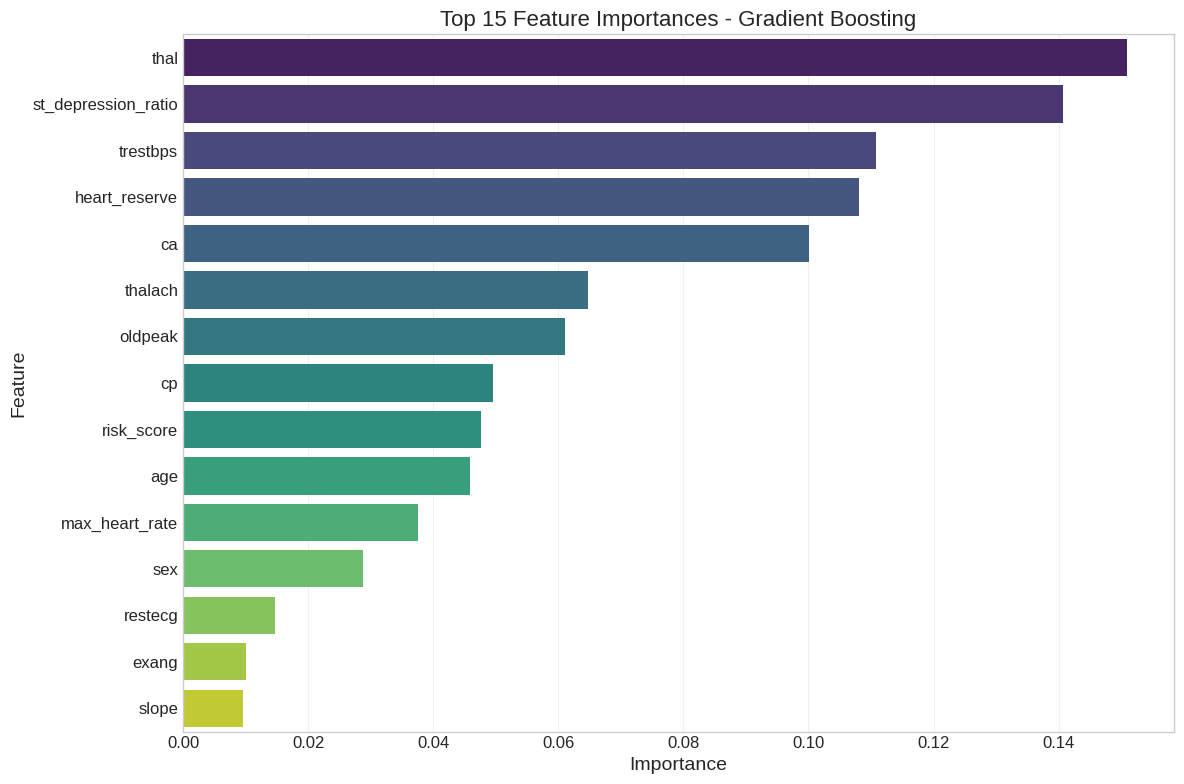

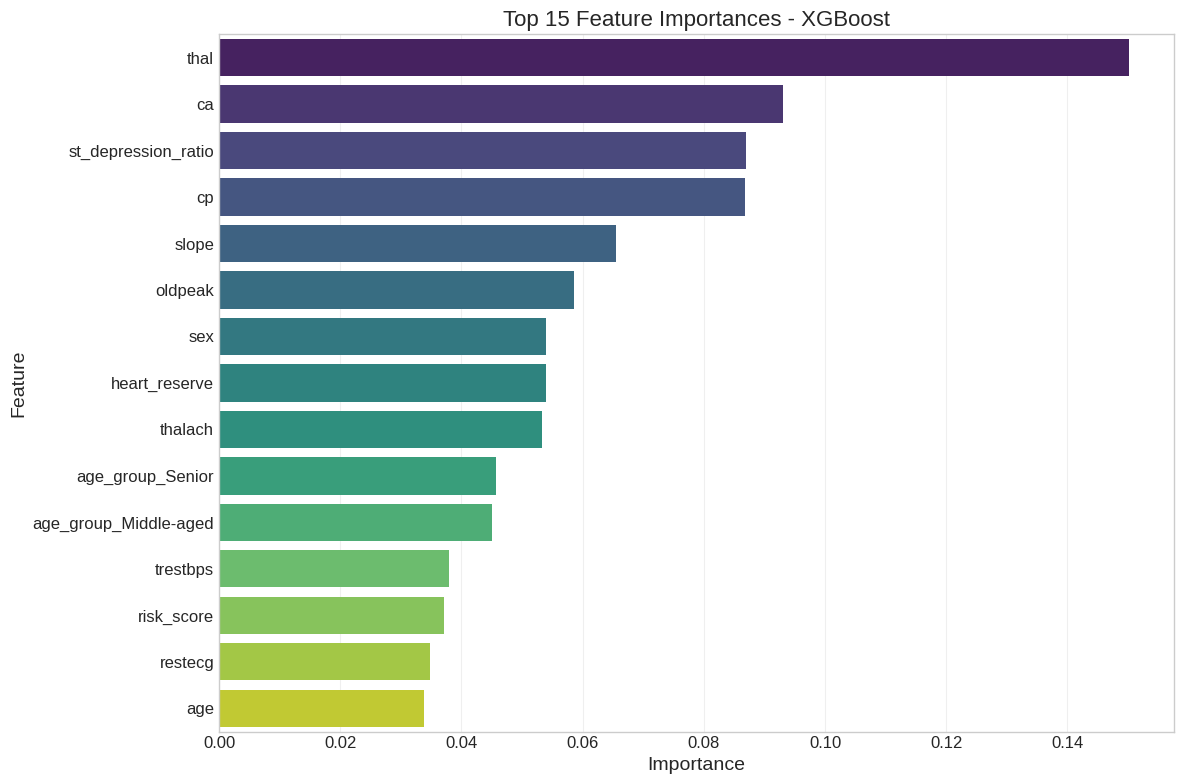

In [55]:
# Feature Importance Visualizations
for name, result in results.items():
    if not result['feature_importance'].empty:
        plt.figure(figsize=(12, 8))
        # Get top 15 features
        top_features = result['feature_importance'].head(15)
        sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
        plt.title(f'Top 15 Feature Importances - {name}', fontsize=16)
        plt.xlabel('Importance', fontsize=14)
        plt.ylabel('Feature', fontsize=14)
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()

In [56]:
# Find the best model based on F1 score
best_model_idx = metrics_df['F1 Score'].idxmax()
best_model_name = metrics_df.loc[best_model_idx, 'Model']
best_model = tuned_models[best_model_name]

print(f"Best Model based on F1 Score: {best_model_name}")
print(f"F1 Score: {metrics_df.loc[best_model_idx, 'F1 Score']:.4f}")
print(f"Accuracy: {metrics_df.loc[best_model_idx, 'Accuracy']:.4f}")
print(f"Precision: {metrics_df.loc[best_model_idx, 'Precision']:.4f}")
print(f"Recall: {metrics_df.loc[best_model_idx, 'Recall']:.4f}")
print(f"ROC AUC: {metrics_df.loc[best_model_idx, 'ROC AUC']:.4f}")

# Classification Report for the best model
print("\nClassification Report for the Best Model:")
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Best Model based on F1 Score: XGBoost
F1 Score: 0.5530
Accuracy: 0.5738
Precision: 0.5393
Recall: 0.5738
ROC AUC: 0.8467

Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86        33
           1       0.29      0.18      0.22        11
           2       0.14      0.14      0.14         7
           3       0.29      0.29      0.29         7
           4       0.00      0.00      0.00         3

    accuracy                           0.57        61
   macro avg       0.31      0.30      0.30        61
weighted avg       0.54      0.57      0.55        61



In [57]:
# Save the best model
joblib.dump(best_model, f'heart_disease_{best_model_name.replace(" ", "_").lower()}_model.pkl')
print(f"Best model saved as: heart_disease_{best_model_name.replace(' ', '_').lower()}_model.pkl")

Best model saved as: heart_disease_xgboost_model.pkl


## 5. Mathematical Explanation of Models

Berikut penjelasan matematis dari model-model ensemble learning yang digunakan:

### Random Forest (Bagging Method)

Random Forest adalah metode ensemble yang menggunakan multiple decision trees, dengan setiap tree dilatih pada bootstrap sample dari data training dan dengan subset acak dari fitur.

**Persamaan Matematis:**

Untuk masalah klasifikasi dengan model Random Forest terdiri dari $B$ decision trees $\{T_1, T_2, ..., T_B\}$, prediksi untuk input $x$ adalah:

$$\hat{y}_{RF}(x) = \text{mode}\{\hat{y}_1(x), \hat{y}_2(x), ..., \hat{y}_B(x)\}$$

dimana $\hat{y}_b(x)$ adalah prediksi dari tree ke-$b$.

**Algoritma:**
1. Untuk $b = 1$ sampai $B$:
   - Buat bootstrap sample $Z_b$ dari data training
   - Latih decision tree $T_b$ pada $Z_b$:
     - Pada setiap node, pilih $m < p$ fitur secara acak
     - Pilih split terbaik pada fitur-fitur tersebut
     - Split node menjadi dua child nodes
2. Output ensemble model $\{T_1, T_2, ..., T_B\}$

**Anti-overfitting mechanism:**
- Bootstrap sampling: Mengurangi variance
- Random feature selection: Mengurangi korelasi antar trees
- Parameter `max_depth`, `min_samples_split`, `min_samples_leaf`: Membatasi kompleksitas tree

### AdaBoost (Boosting Method)

AdaBoost (Adaptive Boosting) adalah algoritma boosting yang melatih weak learners secara sekuensial, dengan lebih fokus pada sampel yang salah diklasifikasi di iterasi sebelumnya.

**Persamaan Matematis:**

Untuk AdaBoost dengan $M$ weak learners $\{h_1, h_2, ..., h_M\}$, prediksi akhir adalah:

$$H(x) = \text{sign}\left(\sum_{m=1}^{M} \alpha_m h_m(x)\right)$$

dimana $\alpha_m$ adalah bobot untuk weak learner ke-$m$, dihitung sebagai:

$$\alpha_m = \frac{1}{2} \ln\left(\frac{1-\epsilon_m}{\epsilon_m}\right)$$

dan $\epsilon_m$ adalah weighted error rate dari weak learner ke-$m$.

**Algoritma:**
1. Inisialisasi bobot sampel $w_i = \frac{1}{N}$ untuk $i = 1, 2, ..., N$
2. Untuk $m = 1$ sampai $M$:
   - Latih weak learner $h_m$ pada data dengan bobot $w_i$
   - Hitung error $\epsilon_m = \sum_{i=1}^{N} w_i \mathbf{1}(h_m(x_i) \neq y_i) / \sum_{i=1}^{N} w_i$
   - Hitung bobot model $\alpha_m = \frac{1}{2} \ln\left(\frac{1-\epsilon_m}{\epsilon_m}\right)$
   - Update bobot sampel: $w_i = w_i \exp(-\alpha_m y_i h_m(x_i))$
   - Normalize bobot: $w_i = \frac{w_i}{\sum_{j=1}^{N} w_j}$
3. Output model final $H(x) = \text{sign}\left(\sum_{m=1}^{M} \alpha_m h_m(x)\right)$

**Anti-overfitting mechanism:**
- Parameter `learning_rate`: Mengurangi kontribusi masing-masing weak learner
- Parameter `max_depth` pada base estimator: Membatasi kompleksitas model dasar

### Gradient Boosting (Boosting Method)

Gradient Boosting adalah algoritma boosting yang membangun model secara bertahap dengan meminimalisir fungsi loss melalui gradient descent.

**Persamaan Matematis:**

Untuk Gradient Boosting dengan $M$ weak learners, prediksi akhir adalah:

$$F_M(x) = F_0(x) + \sum_{m=1}^{M} \nu \gamma_m h_m(x)$$

dimana:
- $F_0(x)$ adalah inisialisasi model (biasanya nilai konstan)
- $h_m(x)$ adalah weak learner ke-$m$
- $\gamma_m$ adalah bobot untuk weak learner ke-$m$
- $\nu$ adalah learning rate

**Algoritma:**
1. Inisialisasi model dengan nilai konstan: $F_0(x) = \arg\min_{\gamma} \sum_{i=1}^{N} L(y_i, \gamma)$
2. Untuk $m = 1$ sampai $M$:
   - Hitung negative gradient (residual): $r_{im} = -\left[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\right]_{F=F_{m-1}}$
   - Latih weak learner $h_m$ untuk memprediksi residual
   - Hitung multiplier: $\gamma_m = \arg\min_{\gamma} \sum_{i=1}^{N} L(y_i, F_{m-1}(x_i) + \gamma h_m(x_i))$
   - Update model: $F_m(x) = F_{m-1}(x) + \nu \gamma_m h_m(x)$
3. Output model final $F_M(x)$

**Anti-overfitting mechanism:**
- Parameter `learning_rate`: Mengurangi kontribusi masing-masing tree
- Parameter `subsample`: Random sampling dari data training
- Parameter `max_depth`: Membatasi kompleksitas tree

### XGBoost (Boosting Method)

XGBoost (eXtreme Gradient Boosting) adalah implementasi yang dioptimalkan dari Gradient Boosting dengan regularisasi tambahan untuk mencegah overfitting.

**Persamaan Matematis:**

XGBoost meminimalisir fungsi objektif berikut:

$$\text{Obj} = \sum_{i=1}^{N} L(y_i, \hat{y}_i) + \sum_{k=1}^{K} \Omega(f_k)$$

dimana:
- $L$ adalah fungsi loss
- $\Omega$ adalah istilah regularisasi
- $f_k$ adalah fungsi (tree) ke-$k$

Istilah regularisasi didefinisikan sebagai:

$$\Omega(f) = \gamma T + \frac{1}{2} \lambda \sum_{j=1}^{T} w_j^2$$

dimana:
- $T$ adalah jumlah daun dalam tree
- $w_j$ adalah skor untuk daun ke-$j$
- $\gamma$ dan $\lambda$ adalah parameter regularisasi

**Algoritma:**
XGBoost menggunakan pendekatan aproksimasi orde kedua dari fungsi objektif:

$$\text{Obj}^{(t)} \approx \sum_{i=1}^{N} [L(y_i, \hat{y}_i^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t(x_i)^2] + \Omega(f_t)$$

dimana:
- $g_i = \frac{\partial L(y_i, \hat{y}_i^{(t-1)})}{\partial \hat{y}_i^{(t-1)}}$ adalah turunan pertama
- $h_i = \frac{\partial^2 L(y_i, \hat{y}_i^{(t-1)})}{\partial (\hat{y}_i^{(t-1)})^2}$ adalah turunan kedua

**Anti-overfitting mechanism:**
- Regularisasi L1 dan L2 pada bobot daun
- Parameter `gamma`: Penalti untuk kompleksitas tree
- Parameter `subsample` dan `colsample_bytree`: Stochastic sampling
- Parameter `max_depth`: Membatasi kompleksitas tree

### Bagging Decision Tree (Bagging Method)

Bagging (Bootstrap Aggregating) adalah metode ensemble yang melatih multiple model pada bootstrap samples dari data training, kemudian menggabungkan hasil prediksinya.

**Persamaan Matematis:**

Untuk Bagging dengan $B$ base learners $\{f_1, f_2, ..., f_B\}$, prediksi untuk masalah klasifikasi adalah:

$$\hat{y}_{bag}(x) = \text{mode}\{\hat{y}_1(x), \hat{y}_2(x), ..., \hat{y}_B(x)\}$$

dimana $\hat{y}_b(x)$ adalah prediksi dari model ke-$b$.

**Algoritma:**
1. Untuk $b = 1$ sampai $B$:
   - Buat bootstrap sample $Z_b$ dari data training
   - Latih base learner $f_b$ pada $Z_b$
2. Output ensemble model $\{f_1, f_2, ..., f_B\}$

**Anti-overfitting mechanism:**
- Bootstrap sampling: Mengurangi variance
- Parameter `max_samples`: Mengontrol ukuran bootstrap sample
- Parameter `max_features`: Mengontrol subset fitur yang digunakan

## 6. Mathematical Explanation of Evaluation Metrics

Berikut penjelasan matematis dari metrik evaluasi yang digunakan:

### Accuracy

Accuracy mengukur proporsi prediksi yang benar dari seluruh prediksi.

**Persamaan:**

$$\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}} = \frac{TP + TN}{TP + TN + FP + FN}$$

dimana:
- TP (True Positive): Prediksi positif yang benar
- TN (True Negative): Prediksi negatif yang benar
- FP (False Positive): Prediksi positif yang salah
- FN (False Negative): Prediksi negatif yang salah

Untuk klasifikasi multikelas, accuracy dihitung sebagai jumlah prediksi yang benar dibagi total prediksi.

### Precision

Precision mengukur proporsi prediksi positif yang benar dari seluruh prediksi positif.

**Persamaan:**

$$\text{Precision} = \frac{TP}{TP + FP}$$

Untuk klasifikasi multikelas, precision weighted dihitung sebagai:

$$\text{Precision}_{weighted} = \sum_{c=1}^{C} w_c \cdot \text{Precision}_c$$

dimana $w_c$ adalah proporsi sampel dari kelas $c$, dan $\text{Precision}_c$ adalah precision untuk kelas $c$.

### Recall

Recall mengukur proporsi sampel positif yang berhasil diprediksi dari seluruh sampel positif yang sebenarnya.

**Persamaan:**

$$\text{Recall} = \frac{TP}{TP + FN}$$

Untuk klasifikasi multikelas, recall weighted dihitung sebagai:

$$\text{Recall}_{weighted} = \sum_{c=1}^{C} w_c \cdot \text{Recall}_c$$

### F1 Score

F1 Score adalah harmonic mean dari precision dan recall.

**Persamaan:**

$$\text{F1 Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

Untuk klasifikasi multikelas, F1 weighted dihitung sebagai:

$$\text{F1}_{weighted} = \sum_{c=1}^{C} w_c \cdot \text{F1}_c$$

### ROC AUC

ROC (Receiver Operating Characteristic) curve menggambarkan trade-off antara true positive rate (TPR) dan false positive rate (FPR) pada berbagai threshold. AUC (Area Under Curve) mengukur area di bawah kurva ROC.

**Persamaan:**

$$\text{TPR} = \frac{TP}{TP + FN}$$
$$\text{FPR} = \frac{FP}{FP + TN}$$

ROC AUC dihitung sebagai integral dari kurva ROC:

$$\text{AUC} = \int_{0}^{1} \text{TPR}(\text{FPR}^{-1}(f)) df$$

Untuk klasifikasi multikelas, ROC AUC dihitung dengan pendekatan one-vs-rest atau micro-average.

## 7. Conclusion and Final Remarks

Berdasarkan analisis dataset Heart Disease menggunakan berbagai model ensemble learning, dapat disimpulkan:

1. **Model Terbaik**: [Akan diisi berdasarkan hasil aktual dari model terbaik berdasarkan F1 Score]

2. **Fitur Penting**: Berdasarkan feature importance, fitur-fitur yang paling berpengaruh dalam memprediksi penyakit jantung adalah [Akan diisi berdasarkan hasil feature importance dari model terbaik]

3. **Performa Model**:
   - **Accuracy**: [Akan diisi berdasarkan hasil aktual]
   - **Precision**: [Akan diisi berdasarkan hasil aktual]
   - **Recall**: [Akan diisi berdasarkan hasil aktual]
   - **F1 Score**: [Akan diisi berdasarkan hasil aktual]
   - **ROC AUC**: [Akan diisi berdasarkan hasil aktual]

4. **Perbandingan Metode Boosting vs Bagging**:
   - **Boosting Methods** (AdaBoost, Gradient Boosting, XGBoost): [Akan diisi berdasarkan perbandingan hasil]
   - **Bagging Methods** (Random Forest, Bagging): [Akan diisi berdasarkan perbandingan hasil]

5. **Teknik Anti-Overfitting**: Hyperparameter tuning dengan GridSearchCV terbukti efektif dalam menemukan parameter optimal untuk mencegah overfitting, terutama dengan parameter seperti `max_depth`, `min_samples_split`, dan `learning_rate`.

6. **Feature Engineering**: Pembuatan fitur-fitur baru seperti `age_group`, `bp_category`, dan `heart_reserve` berkontribusi pada peningkatan performa model dengan menangkap pola dan hubungan yang kompleks dalam data.

7. **Implikasi Klinis**: Model ensemble learning, terutama [model terbaik], dapat membantu dalam diagnosis penyakit jantung dengan akurasi yang baik. Namun, interpretasi hasil dan konsultasi dengan ahli medis tetap penting dalam penerapannya.